<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\stft"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

In [3]:
eeg_fold_1.shape

(1065, 224, 224, 3)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [4]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [5]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [7]:
debug_mode_flag = False
import torch
import torch.nn as nn

class CustomCnn(nn.Module):
    def __init__(self, debug_mode_flag=False):
        super().__init__()
        self.debug_mode_flag = debug_mode_flag
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Further reduces spatial size
        )

        # Global Average Pooling to reduce spatial dimensions 
        self.global_avg_pool = nn.AdaptiveAvgPool2d((8, 8))  # Keeps a manageable seq_len
        self.flatten = nn.Flatten(start_dim=2)  # Keeps batch & channel dims

    def forward(self, x):
        if self.debug_mode_flag: print(f"Input shape: {x.shape}")
        
        x = self.block_1(x)
        if self.debug_mode_flag: print(f"Block 1 shape: {x.shape}")
        
        x = self.block_2(x)
        if self.debug_mode_flag: print(f"Block 2 shape: {x.shape}")
        
        x = self.global_avg_pool(x)  # (batch, 128, 8, 8)
        if self.debug_mode_flag: print(f"Global Avg Pool shape: {x.shape}")

        # x = self.flatten(x)  # (batch, 128, 64)
        # if self.debug_mode_flag: print(f"Flattened shape (Transformer Input): {x.shape}")
        
        return x

    
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TRANS_CNN(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=512, num_heads=2, ff_dim=64, num_transformer_blocks=4):
        
        super(TRANS_CNN,self).__init__()
        
        self.num_transformer_blocks = num_transformer_blocks
        self.cnn_extractor = CustomCnn()
        
        self.projection = nn.Linear(512, embed_dim)
        
        self.encoder = nn.ModuleList([
            TransformerEncoder(embed_dim,num_heads,ff_dim) for _ in range(num_transformer_blocks)
        ])
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        
        self.precls = nn.Linear(embed_dim,embed_dim)
        self.precls2 = nn.Linear(embed_dim,embed_dim)
        self.precls3 = nn.Linear(embed_dim,embed_dim//4)
        
        self.clf = nn.Linear(embed_dim//4,num_classes)
        
        
    def forward(self,x):
        
        x = self.cnn_extractor(x)
        if debug_mode_flag: print(f"x shape after cnn extraction = {x.shape}")
        
        B,C,H,W = x.shape
        
        x = x.view(B,H*W,C)
        if debug_mode_flag: print(f"x shape after changing view= {x.shape}")
        
        # x = self.projection(x)
        # if debug_mode_flag: print(f"x shape after projection= {x.shape}")
        
        for encoderblock in self.encoder:
            x = encoderblock(x)
            
        if debug_mode_flag: print(f"x shape after passing thru encoder= {x.shape}")
        
        x = x.permute(1,0,2)
        if debug_mode_flag: print(f"x shape after permuting{x.shape}")
        
        x = self.precls3(x)
        if debug_mode_flag: print(f"precls3 {x.shape}")
        
        x = self.dropout(x)
        
        x = x.mean(dim=0)  # Global average pooling over sequence (9 tokens → 1 token)
        if debug_mode_flag: print(f"x shape after average pooling {x.shape}")

        x = self.clf(x)  #they see me rolling
        if debug_mode_flag: print(f"cls {x.shape}")
        
        
        return x

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [8]:
model  = TRANS_CNN(input_shape=(224,224,3),num_classes=3,num_transformer_blocks=4,embed_dim=128) # declare model here
randomdata = torch.randn((1,3,224,224))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [9]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TRANS_CNN                                                    --
├─CustomCnn: 1-1                                             --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2d: 3-1                                      448
│    │    └─BatchNorm2d: 3-2                                 32
│    │    └─ReLU: 3-3                                        --
│    │    └─Conv2d: 3-4                                      4,640
│    │    └─BatchNorm2d: 3-5                                 64
│    │    └─ReLU: 3-6                                        --
│    │    └─MaxPool2d: 3-7                                   --
│    └─Sequential: 2-2                                       --
│    │    └─Conv2d: 3-8                                      18,496
│    │    └─BatchNorm2d: 3-9                                 128
│    │    └─ReLU: 3-10                                       --
│    │    └─Conv2d: 3-11  

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

__________________________________________________
__________________________________________________
__________________________________________________
PARAMS SET 0
num_heads: 32, num_transformer_blocks: 8, learning_rate: 0.0014268683384269449, weight_decay: 0.0003463319958859285, label_smoothing: 0.18
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 3
test on folds: 0
Epoch [1/100], Loss: 1.1361, Accuracy: 0.3173 | Validation Loss: 1.3836, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1131, Accuracy: 0.3399 | Validation Loss: 1.0595, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1097, Accuracy: 0.3305 | Validation Loss: 1.1402, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1051, Accuracy: 0.3315 | Validation Loss: 1.1114, Val

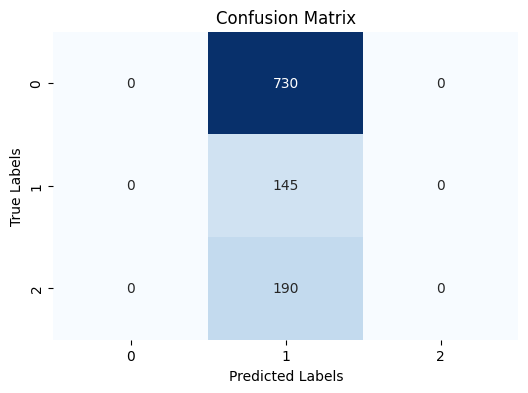


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/730 (0.00%)
Class 1: Correct Predictions / Total True Samples = 145/145 (100.00%)
Class 2: Correct Predictions / Total True Samples = 0/190 (0.00%)

Precision-Recall Curves:


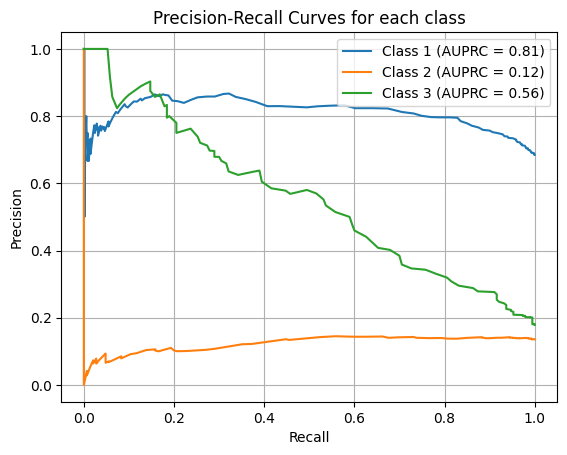


ROC Curves:


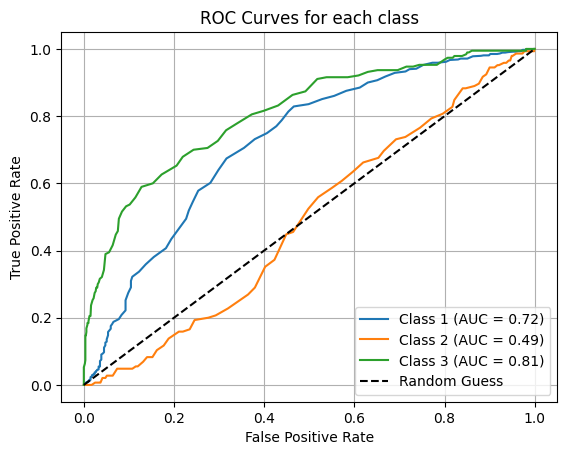


Mean F1 Score: 0.0799
Balanced Accuracy: 0.3333
Average AUPRC: 0.4970

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       730
           1       0.14      1.00      0.24       145
           2       0.00      0.00      0.00       190

    accuracy                           0.14      1065
   macro avg       0.05      0.33      0.08      1065
weighted avg       0.02      0.14      0.03      1065

__________________________________________________
Fold No: 2
training on folds: [[np.int64(4), np.int64(2), np.int64(3)]]
validation on folds: 0
test on folds: 1


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1554, Accuracy: 0.3314 | Validation Loss: 1.0474, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1111, Accuracy: 0.3187 | Validation Loss: 1.0812, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1084, Accuracy: 0.3216 | Validation Loss: 1.0691, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1073, Accuracy: 0.3129 | Validation Loss: 1.1137, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1034, Accuracy: 0.3090 | Validation Loss: 1.1036, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.1024, Accuracy: 0.3236 | Validation Loss: 1.1293, Validation Accuracy: 0.3333
Epoch [7/100], Loss: 1.1052, Accuracy: 0.3226 | Validation Loss: 1.1177, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.1089, Accuracy: 0.3158 | Validation Loss: 1.1126, Validation Accuracy: 0.3333
Epoch [9/100], Loss: 1.1004, Accuracy: 0.3216 | Validation Loss: 1.0930, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.0998, Accuracy: 0.3441 | Validation Loss: 1.0384, Validation Accura

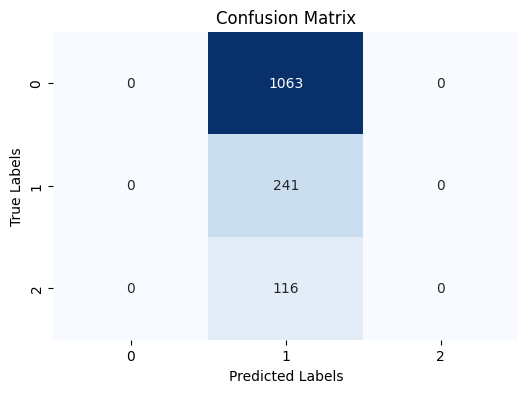


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/1063 (0.00%)
Class 1: Correct Predictions / Total True Samples = 241/241 (100.00%)
Class 2: Correct Predictions / Total True Samples = 0/116 (0.00%)

Precision-Recall Curves:


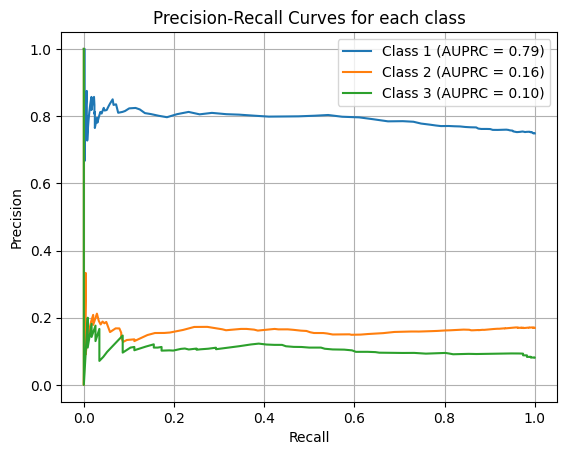


ROC Curves:


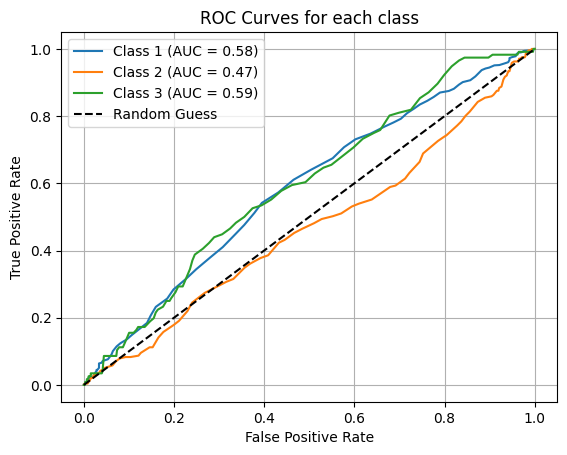


Mean F1 Score: 0.0967
Balanced Accuracy: 0.3333
Average AUPRC: 0.3530

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1063
           1       0.17      1.00      0.29       241
           2       0.00      0.00      0.00       116

    accuracy                           0.17      1420
   macro avg       0.06      0.33      0.10      1420
weighted avg       0.03      0.17      0.05      1420

__________________________________________________
Fold No: 3
training on folds: [[np.int64(0), np.int64(2), np.int64(3)]]
validation on folds: 1
test on folds: 4


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1385, Accuracy: 0.3152 | Validation Loss: 1.1347, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1066, Accuracy: 0.3447 | Validation Loss: 1.4051, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1119, Accuracy: 0.3402 | Validation Loss: 0.9922, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1061, Accuracy: 0.3136 | Validation Loss: 1.0108, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1052, Accuracy: 0.3386 | Validation Loss: 1.0914, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.1028, Accuracy: 0.3341 | Validation Loss: 1.0560, Validation Accuracy: 0.3333
Epoch [7/100], Loss: 1.1016, Accuracy: 0.3318 | Validation Loss: 1.1298, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.1011, Accuracy: 0.2992 | Validation Loss: 1.0824, Validation Accuracy: 0.3333
Epoch [9/100], Loss: 1.1009, Accuracy: 0.3098 | Validation Loss: 1.0668, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.0991, Accuracy: 0.3492 | Validation Loss: 1.1476, Validation Accura

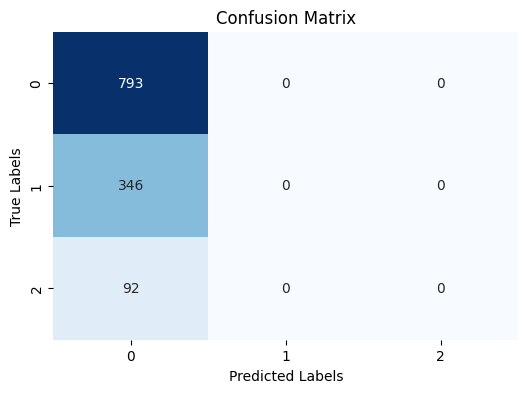


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 793/793 (100.00%)
Class 1: Correct Predictions / Total True Samples = 0/346 (0.00%)
Class 2: Correct Predictions / Total True Samples = 0/92 (0.00%)

Precision-Recall Curves:


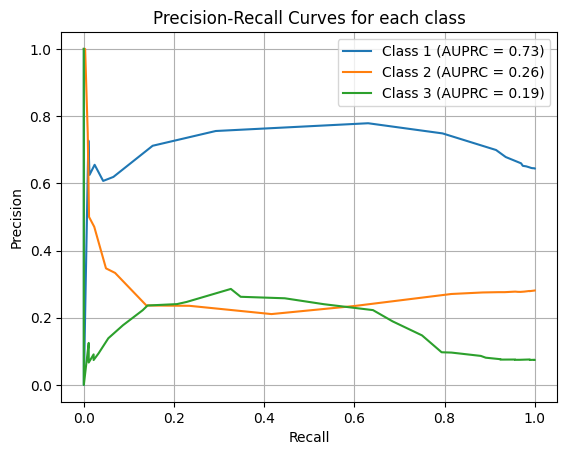


ROC Curves:


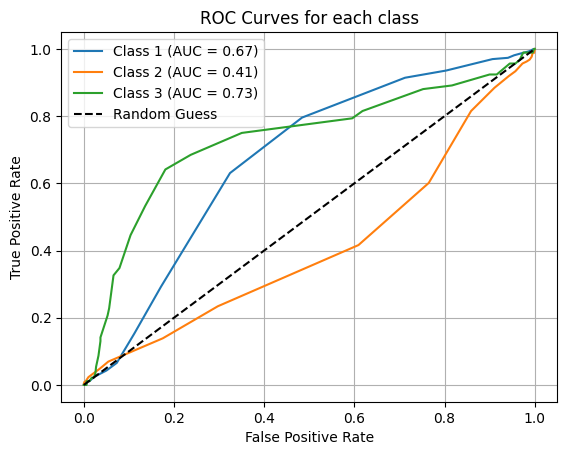


Mean F1 Score: 0.2612
Balanced Accuracy: 0.3333
Average AUPRC: 0.3928

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       793
           1       0.00      0.00      0.00       346
           2       0.00      0.00      0.00        92

    accuracy                           0.64      1231
   macro avg       0.21      0.33      0.26      1231
weighted avg       0.41      0.64      0.50      1231

__________________________________________________
Fold No: 4
training on folds: [[np.int64(0), np.int64(1), np.int64(3)]]
validation on folds: 4
test on folds: 2


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1322, Accuracy: 0.3545 | Validation Loss: 1.0661, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1109, Accuracy: 0.3268 | Validation Loss: 1.0338, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1067, Accuracy: 0.3407 | Validation Loss: 1.0973, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1070, Accuracy: 0.3488 | Validation Loss: 1.0283, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1078, Accuracy: 0.3130 | Validation Loss: 1.0935, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.1028, Accuracy: 0.3374 | Validation Loss: 1.0852, Validation Accuracy: 0.3333
Epoch [7/100], Loss: 1.1003, Accuracy: 0.3463 | Validation Loss: 1.1045, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.0998, Accuracy: 0.3244 | Validation Loss: 1.1065, Validation Accuracy: 0.3333
Epoch [9/100], Loss: 1.1020, Accuracy: 0.3179 | Validation Loss: 1.0784, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.1011, Accuracy: 0.3154 | Validation Loss: 1.1090, Validation Accura

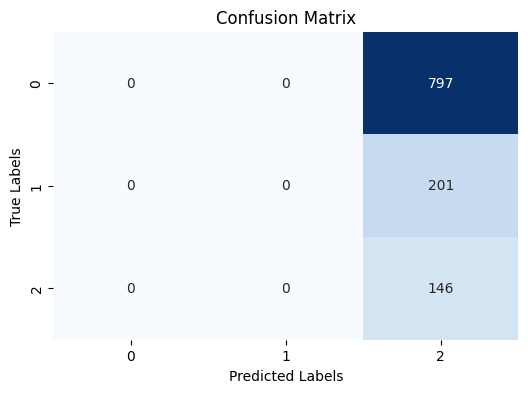


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/797 (0.00%)
Class 1: Correct Predictions / Total True Samples = 0/201 (0.00%)
Class 2: Correct Predictions / Total True Samples = 146/146 (100.00%)

Precision-Recall Curves:


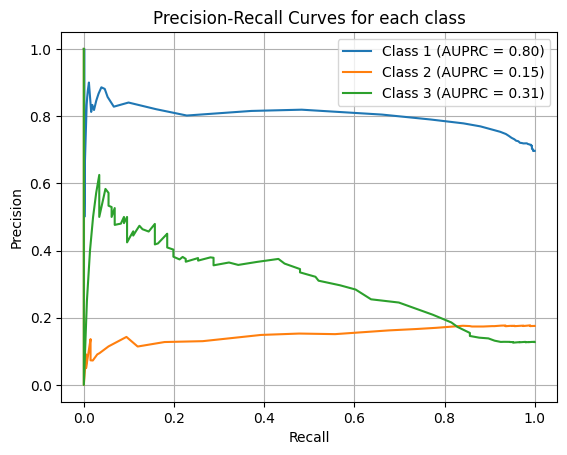


ROC Curves:


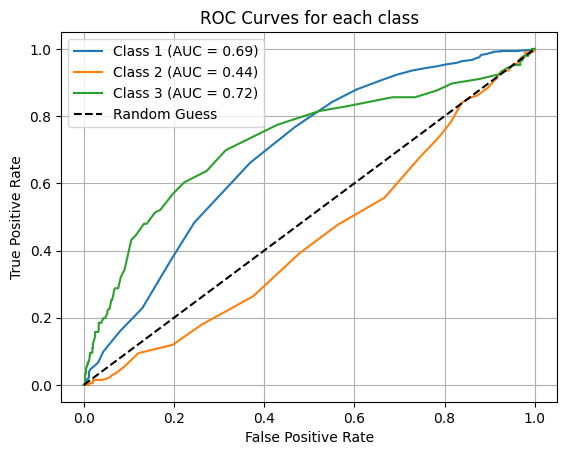


Mean F1 Score: 0.0755
Balanced Accuracy: 0.3333
Average AUPRC: 0.4197

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       797
           1       0.00      0.00      0.00       201
           2       0.13      1.00      0.23       146

    accuracy                           0.13      1144
   macro avg       0.04      0.33      0.08      1144
weighted avg       0.02      0.13      0.03      1144

__________________________________________________
Fold No: 5
training on folds: [[np.int64(0), np.int64(1), np.int64(4)]]
validation on folds: 2
test on folds: 3


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1481, Accuracy: 0.3191 | Validation Loss: 1.0740, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1098, Accuracy: 0.3392 | Validation Loss: 1.0255, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1057, Accuracy: 0.3090 | Validation Loss: 1.1409, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1050, Accuracy: 0.3451 | Validation Loss: 1.0662, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1050, Accuracy: 0.3317 | Validation Loss: 1.1244, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.1048, Accuracy: 0.3023 | Validation Loss: 1.1558, Validation Accuracy: 0.3333
Epoch [7/100], Loss: 1.1050, Accuracy: 0.3049 | Validation Loss: 1.1337, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.1032, Accuracy: 0.3258 | Validation Loss: 1.1552, Validation Accuracy: 0.3333
Epoch [9/100], Loss: 1.1029, Accuracy: 0.3174 | Validation Loss: 1.1180, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.0999, Accuracy: 0.3367 | Validation Loss: 1.1111, Validation Accura

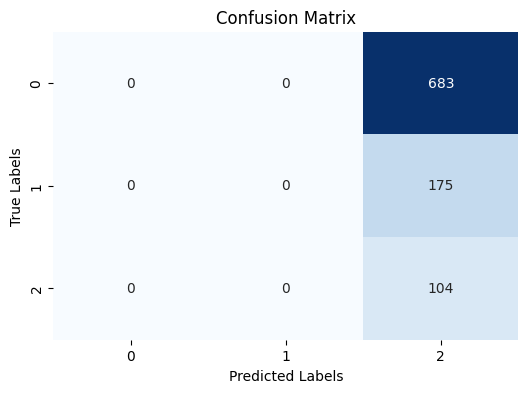


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/683 (0.00%)
Class 1: Correct Predictions / Total True Samples = 0/175 (0.00%)
Class 2: Correct Predictions / Total True Samples = 104/104 (100.00%)

Precision-Recall Curves:


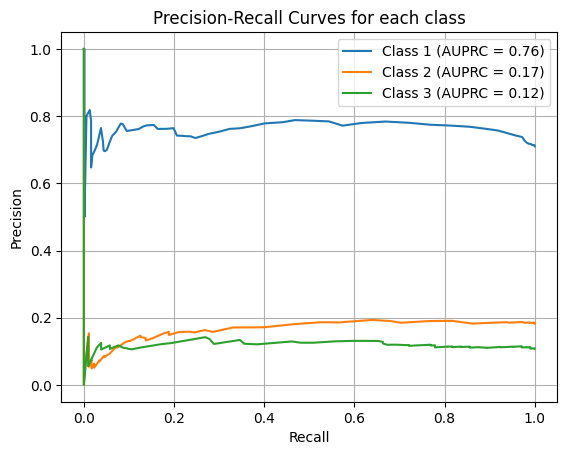


ROC Curves:


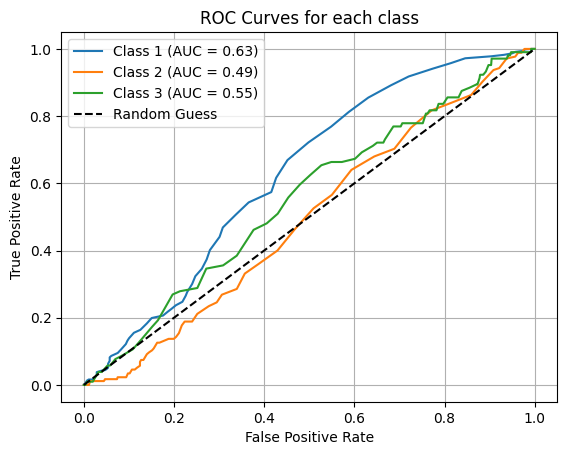


Mean F1 Score: 0.0650
Balanced Accuracy: 0.3333
Average AUPRC: 0.3510

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       683
           1       0.00      0.00      0.00       175
           2       0.11      1.00      0.20       104

    accuracy                           0.11       962
   macro avg       0.04      0.33      0.07       962
weighted avg       0.01      0.11      0.02       962

Accuracy for each fold: [np.float64(0.3333333333333333), np.float64(0.3333333333333333), np.float64(0.3333333333333333), np.float64(0.3333333333333333), np.float64(0.3333333333333333)]
AUPRC for each fold: [np.float64(0.49703694775948054), np.float64(0.35295221695795154), np.float64(0.3928388943604892), np.float64(0.4196801707943221), np.float64(0.351015039966549)]
Average AUPRC across all folds: 0.40270465396775845
Average Balanced Accuracy across all folds: 0.3333333333333333
_________________________________________

c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1381, Accuracy: 0.3652 | Validation Loss: 1.0456, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1167, Accuracy: 0.3375 | Validation Loss: 1.1497, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1085, Accuracy: 0.3275 | Validation Loss: 1.0792, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1038, Accuracy: 0.3183 | Validation Loss: 1.2051, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1054, Accuracy: 0.3275 | Validation Loss: 1.0824, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.0922, Accuracy: 0.3593 | Validation Loss: 1.3949, Validation Accuracy: 0.3340
Epoch [7/100], Loss: 1.1099, Accuracy: 0.3350 | Validation Loss: 1.0732, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.1029, Accuracy: 0.3099 | Validation Loss: 1.0963, Validation Accuracy: 0.3341
Epoch [9/100], Loss: 1.1008, Accuracy: 0.3124 | Validation Loss: 1.0550, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.1014, Accuracy: 0.3476 | Validation Loss: 1.0639, Validation Accura

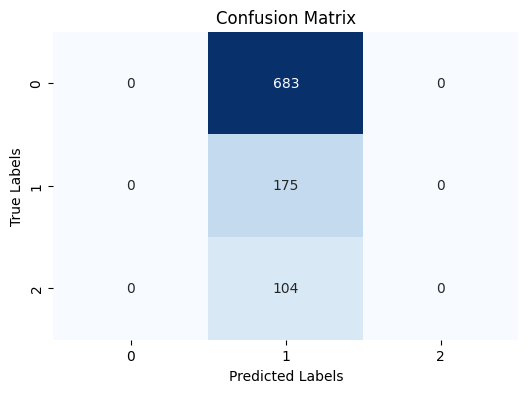


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/683 (0.00%)
Class 1: Correct Predictions / Total True Samples = 175/175 (100.00%)
Class 2: Correct Predictions / Total True Samples = 0/104 (0.00%)

Precision-Recall Curves:


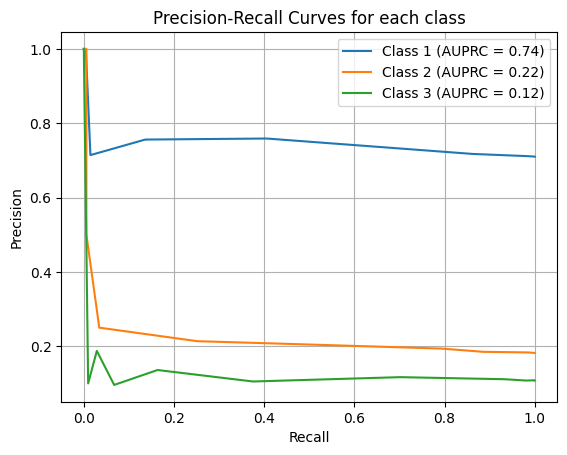


ROC Curves:


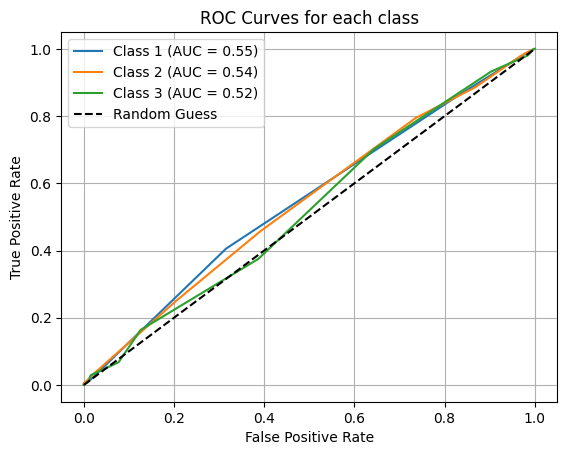


Mean F1 Score: 0.1026
Balanced Accuracy: 0.3333
Average AUPRC: 0.3593

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       683
           1       0.18      1.00      0.31       175
           2       0.00      0.00      0.00       104

    accuracy                           0.18       962
   macro avg       0.06      0.33      0.10       962
weighted avg       0.03      0.18      0.06       962

__________________________________________________
Fold No: 2
training on folds: [[np.int64(4), np.int64(1), np.int64(2)]]
validation on folds: 3
test on folds: 0


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1373, Accuracy: 0.3362 | Validation Loss: 1.0981, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1251, Accuracy: 0.3107 | Validation Loss: 1.2104, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1038, Accuracy: 0.3324 | Validation Loss: 1.1638, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1048, Accuracy: 0.3183 | Validation Loss: 1.0896, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1054, Accuracy: 0.3098 | Validation Loss: 1.0764, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.1034, Accuracy: 0.3437 | Validation Loss: 1.1210, Validation Accuracy: 0.3333
Epoch [7/100], Loss: 1.1021, Accuracy: 0.3493 | Validation Loss: 1.1967, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.1044, Accuracy: 0.3098 | Validation Loss: 1.1569, Validation Accuracy: 0.3333
Epoch [9/100], Loss: 1.1027, Accuracy: 0.3277 | Validation Loss: 1.0761, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.1001, Accuracy: 0.3371 | Validation Loss: 1.0931, Validation Accura

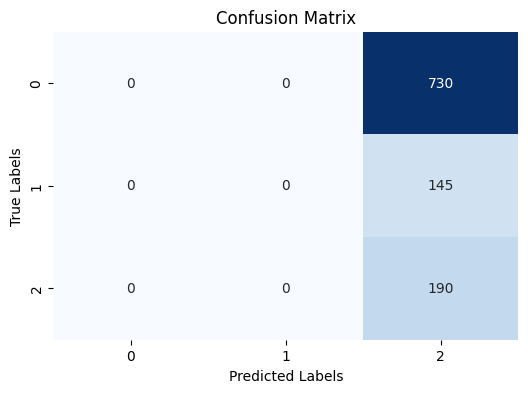


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/730 (0.00%)
Class 1: Correct Predictions / Total True Samples = 0/145 (0.00%)
Class 2: Correct Predictions / Total True Samples = 190/190 (100.00%)

Precision-Recall Curves:


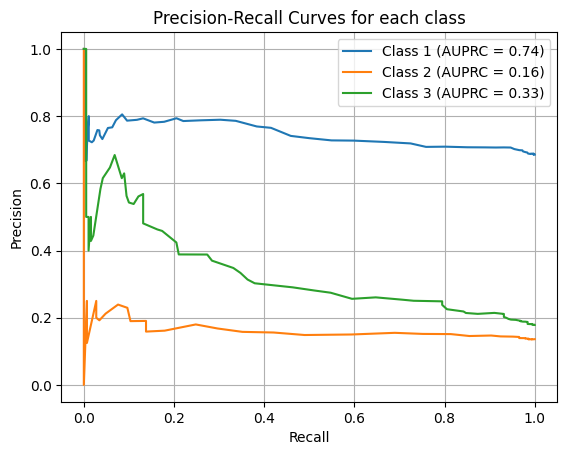


ROC Curves:


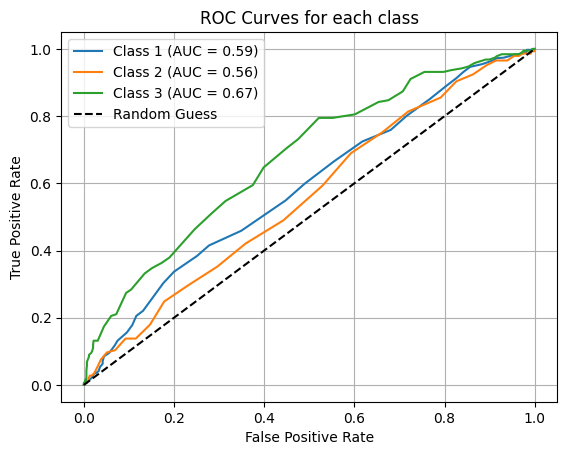


Mean F1 Score: 0.1009
Balanced Accuracy: 0.3333
Average AUPRC: 0.4117

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       730
           1       0.00      0.00      0.00       145
           2       0.18      1.00      0.30       190

    accuracy                           0.18      1065
   macro avg       0.06      0.33      0.10      1065
weighted avg       0.03      0.18      0.05      1065

__________________________________________________
Fold No: 3
training on folds: [[np.int64(3), np.int64(1), np.int64(2)]]
validation on folds: 0
test on folds: 4


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1463, Accuracy: 0.3352 | Validation Loss: 1.1376, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1093, Accuracy: 0.3078 | Validation Loss: 1.1097, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1004, Accuracy: 0.3534 | Validation Loss: 1.1669, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1054, Accuracy: 0.3024 | Validation Loss: 1.0865, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1060, Accuracy: 0.3133 | Validation Loss: 1.0294, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.1034, Accuracy: 0.3479 | Validation Loss: 1.1025, Validation Accuracy: 0.3333
Epoch [7/100], Loss: 1.1081, Accuracy: 0.3251 | Validation Loss: 1.1592, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.1020, Accuracy: 0.3233 | Validation Loss: 1.0849, Validation Accuracy: 0.3333
Epoch [9/100], Loss: 1.1012, Accuracy: 0.3424 | Validation Loss: 1.0914, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.1019, Accuracy: 0.3297 | Validation Loss: 1.1093, Validation Accura

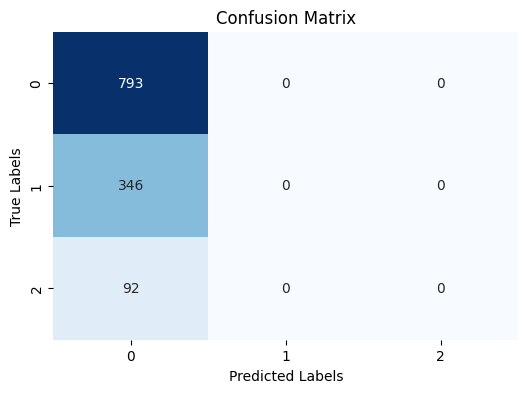


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 793/793 (100.00%)
Class 1: Correct Predictions / Total True Samples = 0/346 (0.00%)
Class 2: Correct Predictions / Total True Samples = 0/92 (0.00%)

Precision-Recall Curves:


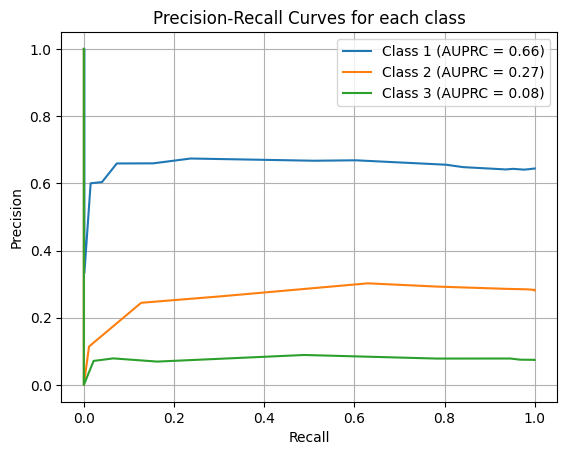


ROC Curves:


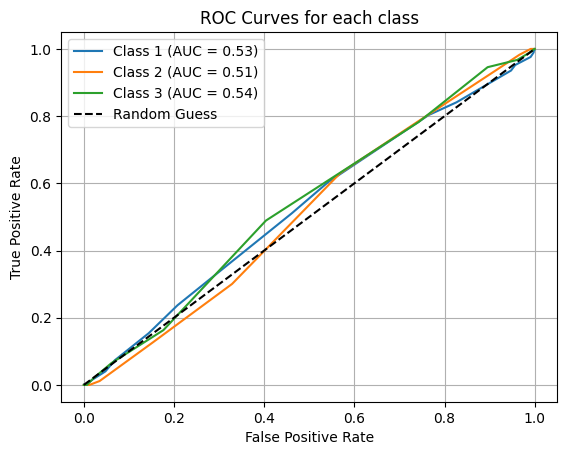


Mean F1 Score: 0.2612
Balanced Accuracy: 0.3333
Average AUPRC: 0.3341

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       793
           1       0.00      0.00      0.00       346
           2       0.00      0.00      0.00        92

    accuracy                           0.64      1231
   macro avg       0.21      0.33      0.26      1231
weighted avg       0.41      0.64      0.50      1231

__________________________________________________
Fold No: 4
training on folds: [[np.int64(3), np.int64(0), np.int64(2)]]
validation on folds: 4
test on folds: 1


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1343, Accuracy: 0.3333 | Validation Loss: 1.0255, Validation Accuracy: 0.3322
Epoch [2/100], Loss: 1.0249, Accuracy: 0.4379 | Validation Loss: 1.3576, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.0953, Accuracy: 0.3682 | Validation Loss: 1.1130, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1072, Accuracy: 0.3144 | Validation Loss: 1.1182, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1046, Accuracy: 0.3417 | Validation Loss: 1.1217, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.1076, Accuracy: 0.3265 | Validation Loss: 1.0935, Validation Accuracy: 0.3333
Epoch [7/100], Loss: 1.1032, Accuracy: 0.3227 | Validation Loss: 1.1377, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.0994, Accuracy: 0.3508 | Validation Loss: 1.1074, Validation Accuracy: 0.3333
Epoch [9/100], Loss: 1.1044, Accuracy: 0.3197 | Validation Loss: 1.0778, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.1008, Accuracy: 0.3220 | Validation Loss: 1.1235, Validation Accura

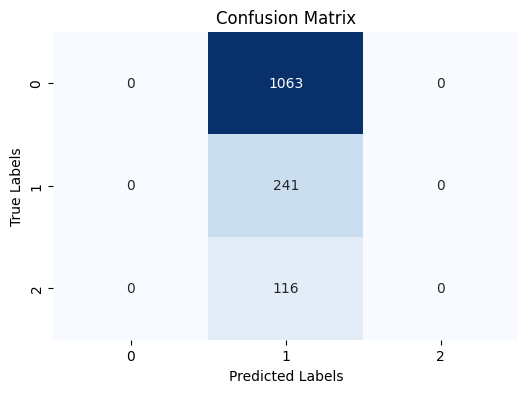


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/1063 (0.00%)
Class 1: Correct Predictions / Total True Samples = 241/241 (100.00%)
Class 2: Correct Predictions / Total True Samples = 0/116 (0.00%)

Precision-Recall Curves:


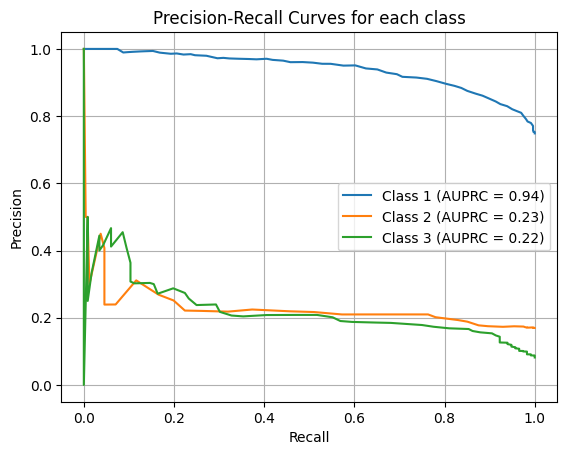


ROC Curves:


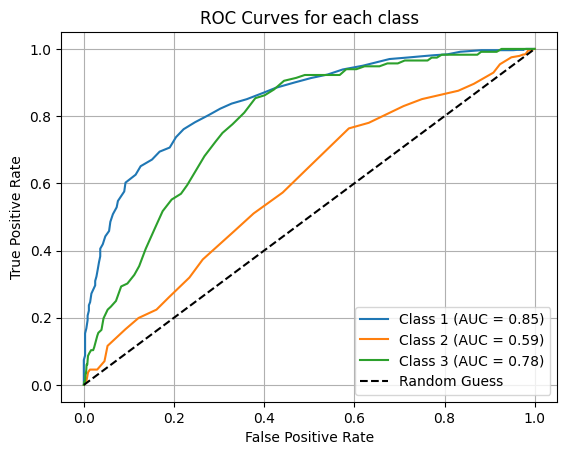


Mean F1 Score: 0.0967
Balanced Accuracy: 0.3333
Average AUPRC: 0.4623

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1063
           1       0.17      1.00      0.29       241
           2       0.00      0.00      0.00       116

    accuracy                           0.17      1420
   macro avg       0.06      0.33      0.10      1420
weighted avg       0.03      0.17      0.05      1420

__________________________________________________
Fold No: 5
training on folds: [[np.int64(3), np.int64(0), np.int64(4)]]
validation on folds: 1
test on folds: 2


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1401, Accuracy: 0.3135 | Validation Loss: 1.0791, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1066, Accuracy: 0.3566 | Validation Loss: 1.1154, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1073, Accuracy: 0.3307 | Validation Loss: 1.0414, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1088, Accuracy: 0.3290 | Validation Loss: 1.0762, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1082, Accuracy: 0.3014 | Validation Loss: 1.1295, Validation Accuracy: 0.3333
Epoch [6/100], Loss: 1.1023, Accuracy: 0.3195 | Validation Loss: 1.1488, Validation Accuracy: 0.3333
Epoch [7/100], Loss: 1.1017, Accuracy: 0.3117 | Validation Loss: 1.1110, Validation Accuracy: 0.3333
Epoch [8/100], Loss: 1.1008, Accuracy: 0.3342 | Validation Loss: 1.0953, Validation Accuracy: 0.3333
Epoch [9/100], Loss: 1.1009, Accuracy: 0.3342 | Validation Loss: 1.0615, Validation Accuracy: 0.3333
Epoch [10/100], Loss: 1.1019, Accuracy: 0.3143 | Validation Loss: 1.0926, Validation Accura

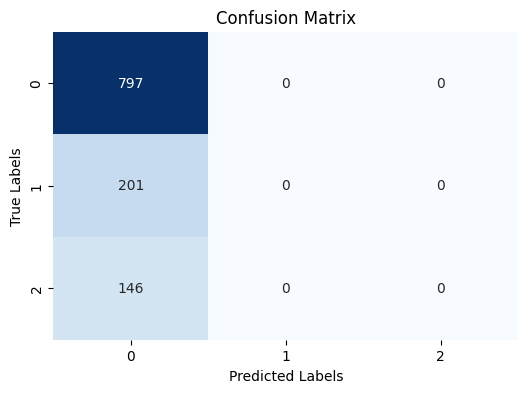


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 797/797 (100.00%)
Class 1: Correct Predictions / Total True Samples = 0/201 (0.00%)
Class 2: Correct Predictions / Total True Samples = 0/146 (0.00%)

Precision-Recall Curves:


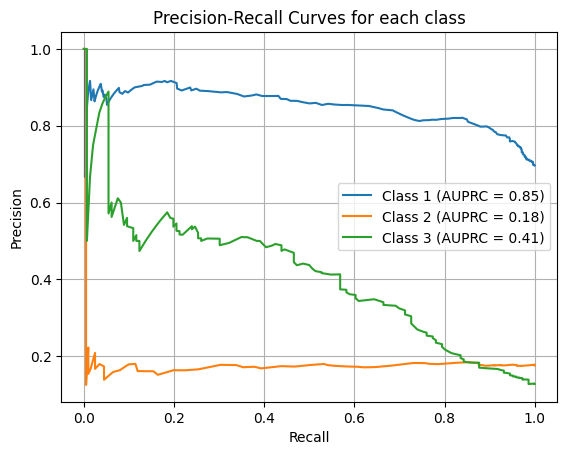


ROC Curves:


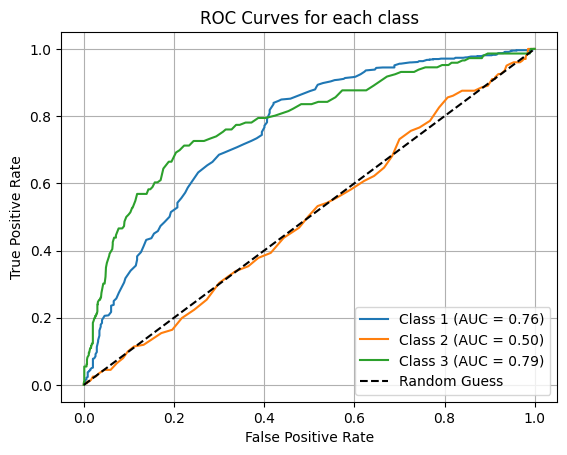


Mean F1 Score: 0.2737
Balanced Accuracy: 0.3333
Average AUPRC: 0.4786

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       797
           1       0.00      0.00      0.00       201
           2       0.00      0.00      0.00       146

    accuracy                           0.70      1144
   macro avg       0.23      0.33      0.27      1144
weighted avg       0.49      0.70      0.57      1144

Accuracy for each fold: [np.float64(0.3333333333333333), np.float64(0.3333333333333333), np.float64(0.3333333333333333), np.float64(0.3333333333333333), np.float64(0.3333333333333333)]
AUPRC for each fold: [np.float64(0.3592669683350406), np.float64(0.4116901045671102), np.float64(0.3340635034683985), np.float64(0.462277580886678), np.float64(0.4786443006257198)]
Average AUPRC across all folds: 0.40918849157658943
Average Balanced Accuracy across all folds: 0.3333333333333333
___________________________________________

c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1260, Accuracy: 0.3371 | Validation Loss: 1.0831, Validation Accuracy: 0.4426
Epoch [2/100], Loss: 1.0010, Accuracy: 0.5687 | Validation Loss: 1.0547, Validation Accuracy: 0.4837
Epoch [3/100], Loss: 0.9351, Accuracy: 0.6478 | Validation Loss: 1.0332, Validation Accuracy: 0.5703
Epoch [4/100], Loss: 0.9054, Accuracy: 0.6780 | Validation Loss: 0.9276, Validation Accuracy: 0.6225
Epoch [5/100], Loss: 0.8842, Accuracy: 0.6996 | Validation Loss: 0.9954, Validation Accuracy: 0.6177
Epoch [6/100], Loss: 0.8607, Accuracy: 0.7269 | Validation Loss: 1.0231, Validation Accuracy: 0.6207
Epoch [7/100], Loss: 0.8411, Accuracy: 0.7335 | Validation Loss: 1.1046, Validation Accuracy: 0.5031
Epoch [8/100], Loss: 0.8417, Accuracy: 0.7411 | Validation Loss: 1.0312, Validation Accuracy: 0.5716
Epoch [9/100], Loss: 0.8069, Accuracy: 0.7721 | Validation Loss: 1.0372, Validation Accuracy: 0.5176
Epoch [10/100], Loss: 0.8067, Accuracy: 0.7806 | Validation Loss: 1.0597, Validation Accura

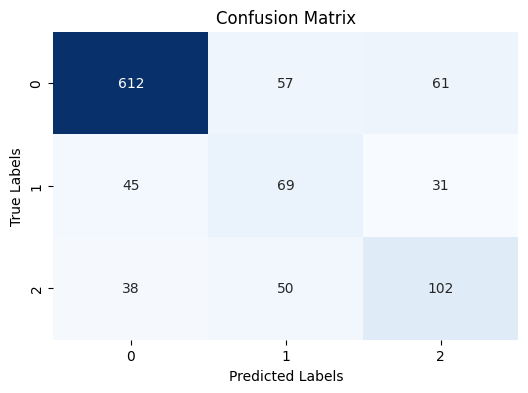


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 612/730 (83.84%)
Class 1: Correct Predictions / Total True Samples = 69/145 (47.59%)
Class 2: Correct Predictions / Total True Samples = 102/190 (53.68%)

Precision-Recall Curves:


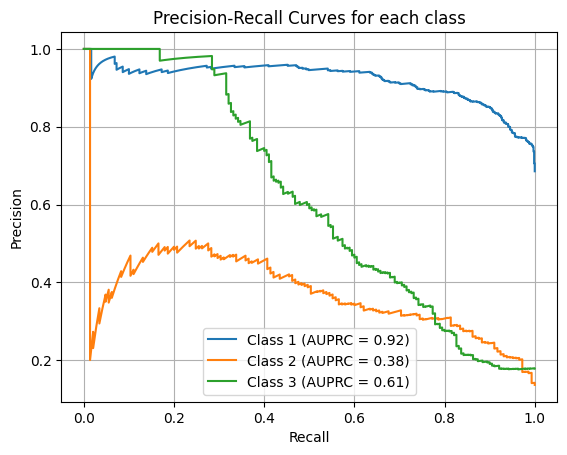


ROC Curves:


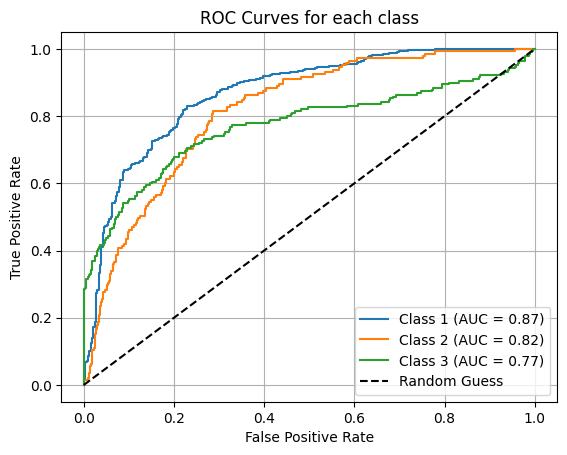


Mean F1 Score: 0.6067
Balanced Accuracy: 0.6170
Average AUPRC: 0.6368

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       730
           1       0.39      0.48      0.43       145
           2       0.53      0.54      0.53       190

    accuracy                           0.74      1065
   macro avg       0.60      0.62      0.61      1065
weighted avg       0.75      0.74      0.74      1065

__________________________________________________
Fold No: 2
training on folds: [[np.int64(4), np.int64(2), np.int64(3)]]
validation on folds: 0
test on folds: 1
Epoch [1/100], Loss: 1.1271, Accuracy: 0.3187 | Validation Loss: 1.1035, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.0343, Accuracy: 0.4981 | Validation Loss: 0.9688, Validation Accuracy: 0.6253
Epoch [3/100], Loss: 0.9627, Accuracy: 0.6306 | Validation Loss: 0.9968, Validation Accuracy: 0.5926
Epoch [4/100], Loss: 0.9227, Accuracy: 0.6637 | Validation

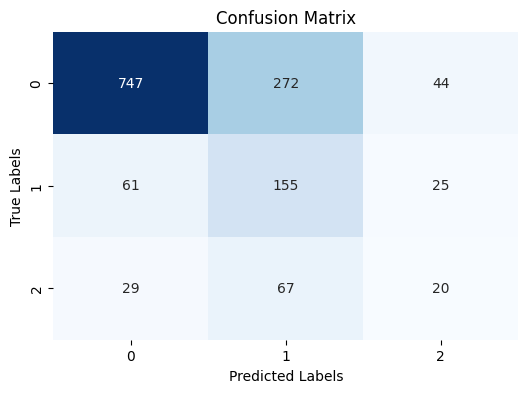


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 747/1063 (70.27%)
Class 1: Correct Predictions / Total True Samples = 155/241 (64.32%)
Class 2: Correct Predictions / Total True Samples = 20/116 (17.24%)

Precision-Recall Curves:


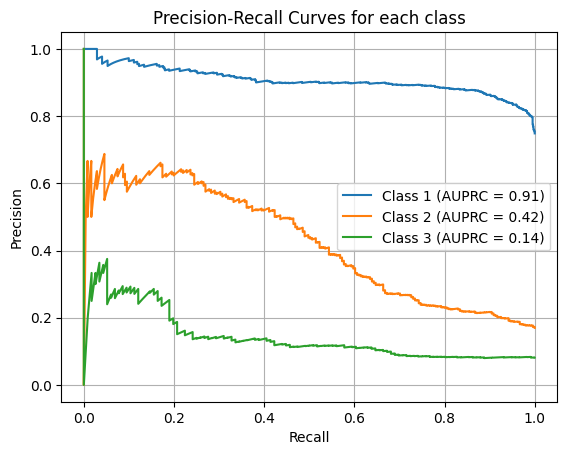


ROC Curves:


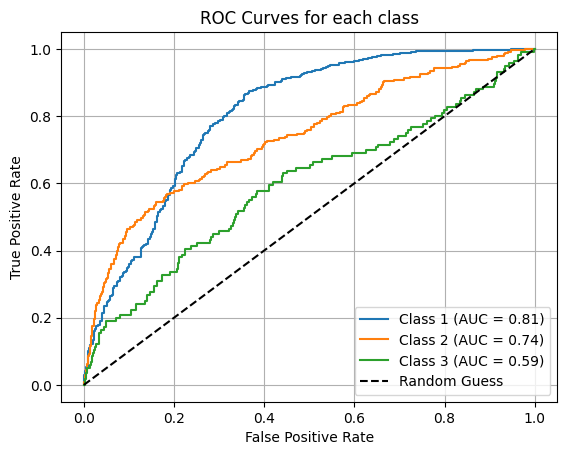


Mean F1 Score: 0.4677
Balanced Accuracy: 0.5061
Average AUPRC: 0.4895

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.79      1063
           1       0.31      0.64      0.42       241
           2       0.22      0.17      0.20       116

    accuracy                           0.65      1420
   macro avg       0.48      0.51      0.47      1420
weighted avg       0.74      0.65      0.68      1420

__________________________________________________
Fold No: 3
training on folds: [[np.int64(0), np.int64(2), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.1210, Accuracy: 0.3621 | Validation Loss: 1.0200, Validation Accuracy: 0.4985
Epoch [2/100], Loss: 0.9603, Accuracy: 0.5917 | Validation Loss: 0.9345, Validation Accuracy: 0.5172
Epoch [3/100], Loss: 0.9320, Accuracy: 0.6424 | Validation Loss: 1.0925, Validation Accuracy: 0.4531
Epoch [4/100], Loss: 0.8961, Accuracy: 0.6629 | Validation

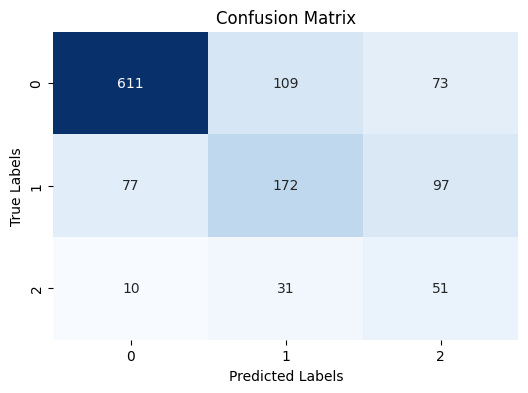


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 611/793 (77.05%)
Class 1: Correct Predictions / Total True Samples = 172/346 (49.71%)
Class 2: Correct Predictions / Total True Samples = 51/92 (55.43%)

Precision-Recall Curves:


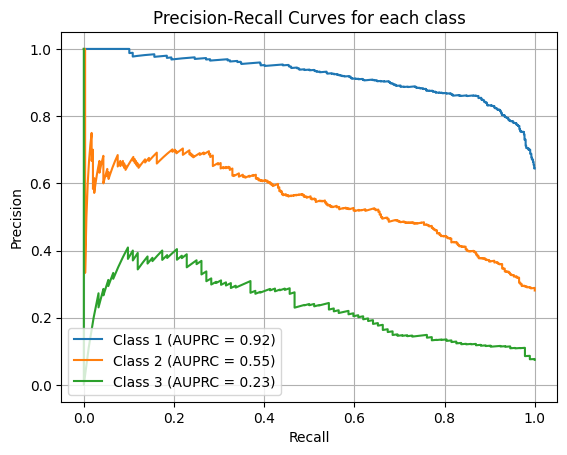


ROC Curves:


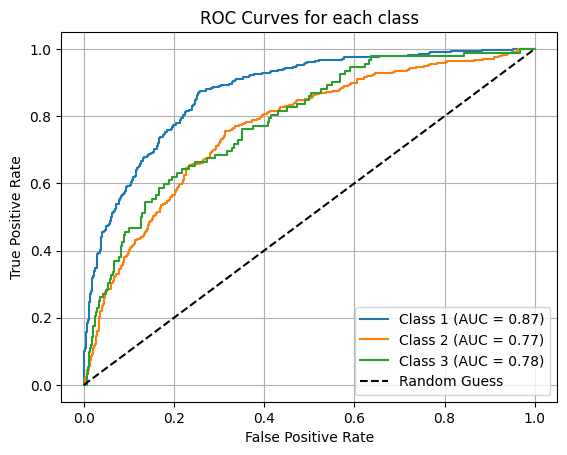


Mean F1 Score: 0.5561
Balanced Accuracy: 0.6073
Average AUPRC: 0.5664

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       793
           1       0.55      0.50      0.52       346
           2       0.23      0.55      0.33        92

    accuracy                           0.68      1231
   macro avg       0.55      0.61      0.56      1231
weighted avg       0.74      0.68      0.70      1231

__________________________________________________
Fold No: 4
training on folds: [[np.int64(0), np.int64(1), np.int64(3)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.0893, Accuracy: 0.3886 | Validation Loss: 1.0771, Validation Accuracy: 0.5136
Epoch [2/100], Loss: 0.9331, Accuracy: 0.6341 | Validation Loss: 1.0732, Validation Accuracy: 0.5416
Epoch [3/100], Loss: 0.9000, Accuracy: 0.6813 | Validation Loss: 0.9554, Validation Accuracy: 0.5570
Epoch [4/100], Loss: 0.8674, Accuracy: 0.7081 | Validation

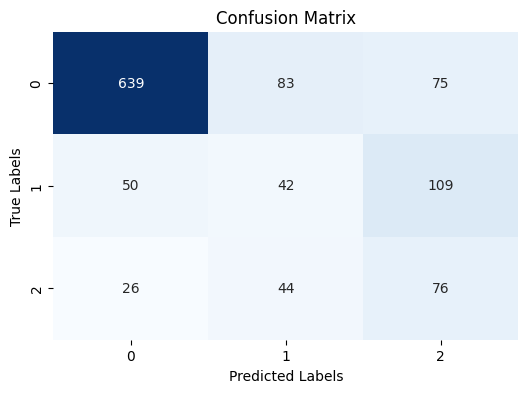


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 639/797 (80.18%)
Class 1: Correct Predictions / Total True Samples = 42/201 (20.90%)
Class 2: Correct Predictions / Total True Samples = 76/146 (52.05%)

Precision-Recall Curves:


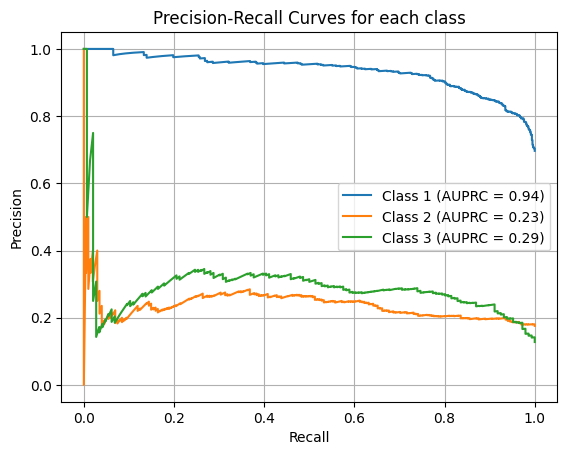


ROC Curves:


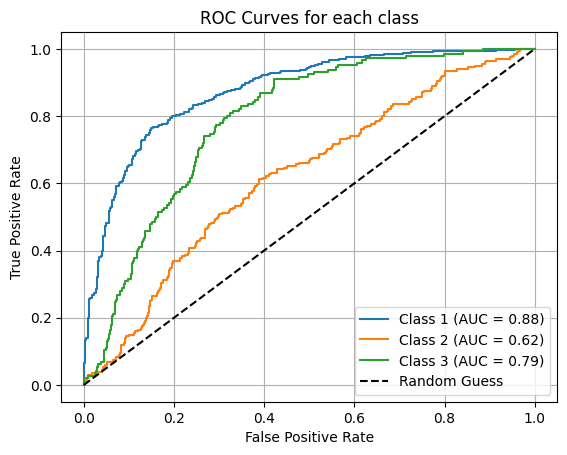


Mean F1 Score: 0.4822
Balanced Accuracy: 0.5104
Average AUPRC: 0.4855

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.85       797
           1       0.25      0.21      0.23       201
           2       0.29      0.52      0.37       146

    accuracy                           0.66      1144
   macro avg       0.48      0.51      0.48      1144
weighted avg       0.70      0.66      0.68      1144

__________________________________________________
Fold No: 5
training on folds: [[np.int64(0), np.int64(1), np.int64(4)]]
validation on folds: 2
test on folds: 3
Epoch [1/100], Loss: 1.0505, Accuracy: 0.4673 | Validation Loss: 1.0225, Validation Accuracy: 0.5391
Epoch [2/100], Loss: 0.9259, Accuracy: 0.6466 | Validation Loss: 0.9362, Validation Accuracy: 0.5732
Epoch [3/100], Loss: 0.8910, Accuracy: 0.6734 | Validation Loss: 0.9657, Validation Accuracy: 0.5774
Epoch [4/100], Loss: 0.8449, Accuracy: 0.7454 | Validation

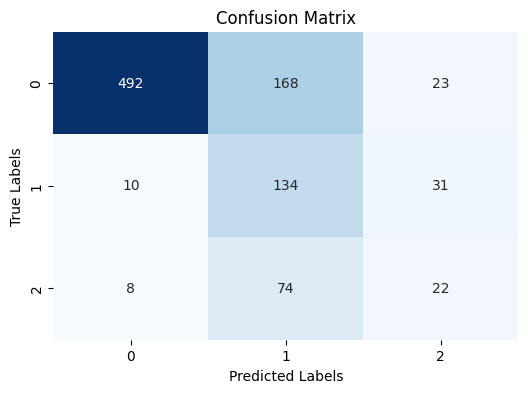


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 492/683 (72.04%)
Class 1: Correct Predictions / Total True Samples = 134/175 (76.57%)
Class 2: Correct Predictions / Total True Samples = 22/104 (21.15%)

Precision-Recall Curves:


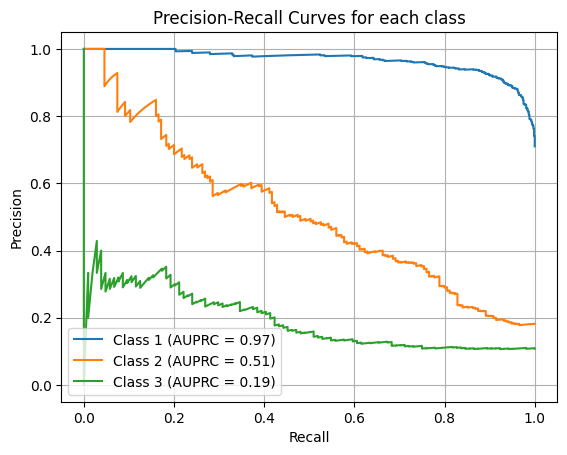


ROC Curves:


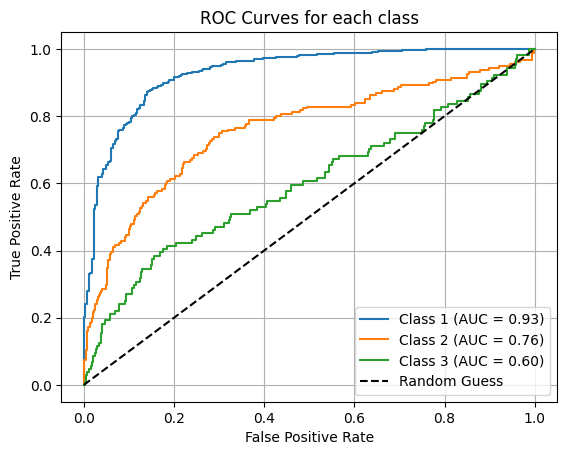


Mean F1 Score: 0.5185
Balanced Accuracy: 0.5659
Average AUPRC: 0.5546

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       683
           1       0.36      0.77      0.49       175
           2       0.29      0.21      0.24       104

    accuracy                           0.67       962
   macro avg       0.54      0.57      0.52       962
weighted avg       0.78      0.67      0.70       962

Accuracy for each fold: [np.float64(0.6170201128707457), np.float64(0.5060984826713986), np.float64(0.6073164853184134), np.float64(0.5104199187626947), np.float64(0.5658680460583828)]
AUPRC for each fold: [np.float64(0.6368209620683255), np.float64(0.48950917959142887), np.float64(0.5663894344659598), np.float64(0.48553138062665563), np.float64(0.5546447743020299)]
Average AUPRC across all folds: 0.5465791462108799
Average Balanced Accuracy across all folds: 0.561344609136327
__________________________________________

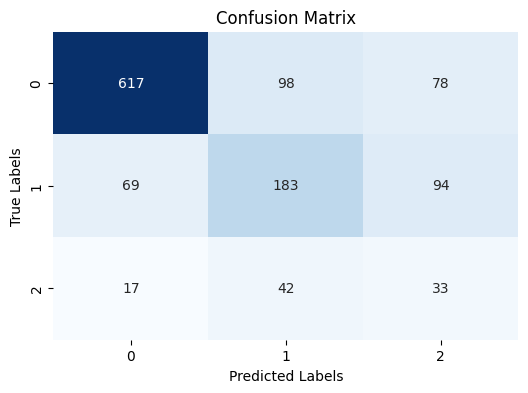


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 617/793 (77.81%)
Class 1: Correct Predictions / Total True Samples = 183/346 (52.89%)
Class 2: Correct Predictions / Total True Samples = 33/92 (35.87%)

Precision-Recall Curves:


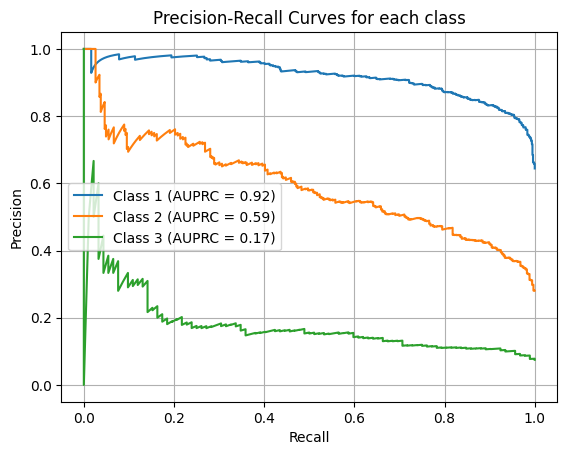


ROC Curves:


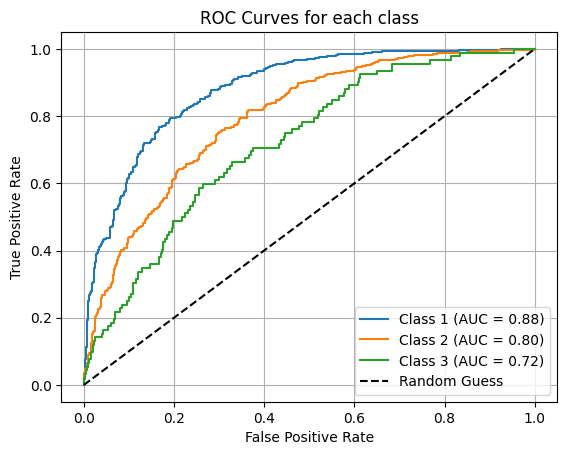


Mean F1 Score: 0.5314
Balanced Accuracy: 0.5552
Average AUPRC: 0.5629

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82       793
           1       0.57      0.53      0.55       346
           2       0.16      0.36      0.22        92

    accuracy                           0.68      1231
   macro avg       0.54      0.56      0.53      1231
weighted avg       0.74      0.68      0.70      1231

__________________________________________________
Fold No: 2
training on folds: [[np.int64(1), np.int64(2), np.int64(0)]]
validation on folds: 4
test on folds: 3
Epoch [1/100], Loss: 1.0710, Accuracy: 0.4469 | Validation Loss: 1.1124, Validation Accuracy: 0.5789
Epoch [2/100], Loss: 0.8903, Accuracy: 0.6003 | Validation Loss: 1.0155, Validation Accuracy: 0.5618
Epoch [3/100], Loss: 0.8273, Accuracy: 0.6563 | Validation Loss: 1.0206, Validation Accuracy: 0.5523
Epoch [4/100], Loss: 0.8180, Accuracy: 0.6704 | Validation

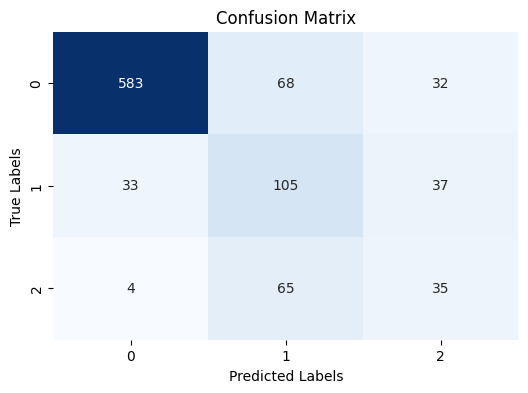


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 583/683 (85.36%)
Class 1: Correct Predictions / Total True Samples = 105/175 (60.00%)
Class 2: Correct Predictions / Total True Samples = 35/104 (33.65%)

Precision-Recall Curves:


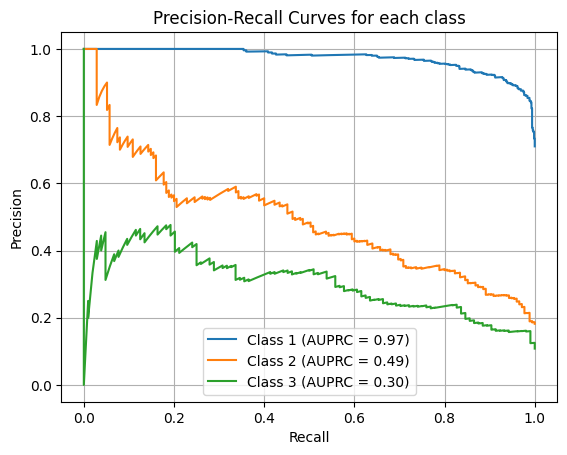


ROC Curves:


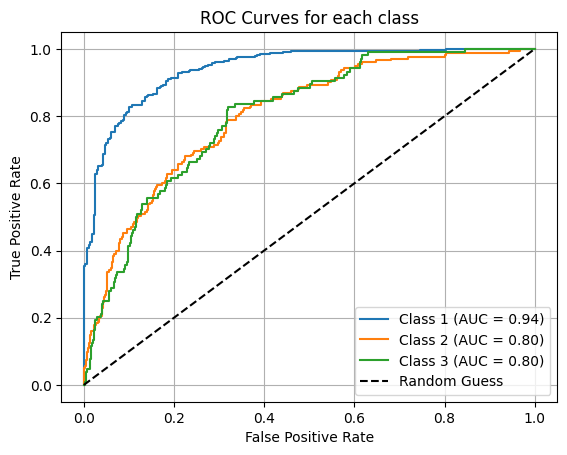


Mean F1 Score: 0.5800
Balanced Accuracy: 0.5967
Average AUPRC: 0.5886

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       683
           1       0.44      0.60      0.51       175
           2       0.34      0.34      0.34       104

    accuracy                           0.75       962
   macro avg       0.57      0.60      0.58       962
weighted avg       0.78      0.75      0.76       962

__________________________________________________
Fold No: 3
training on folds: [[np.int64(4), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 0.9965, Accuracy: 0.4984 | Validation Loss: 1.0024, Validation Accuracy: 0.5391
Epoch [2/100], Loss: 0.8370, Accuracy: 0.6612 | Validation Loss: 1.0428, Validation Accuracy: 0.5156
Epoch [3/100], Loss: 0.8056, Accuracy: 0.6986 | Validation Loss: 1.0883, Validation Accuracy: 0.5225
Epoch [4/100], Loss: 0.7506, Accuracy: 0.7290 | Validation

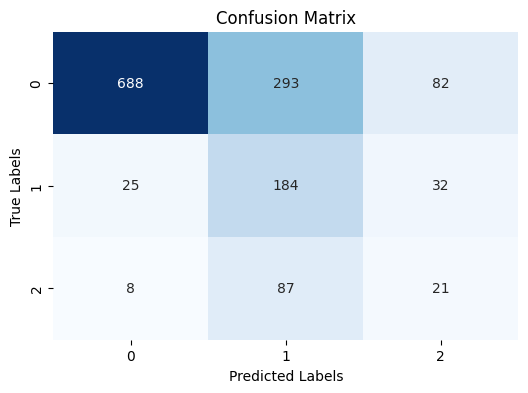


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 688/1063 (64.72%)
Class 1: Correct Predictions / Total True Samples = 184/241 (76.35%)
Class 2: Correct Predictions / Total True Samples = 21/116 (18.10%)

Precision-Recall Curves:


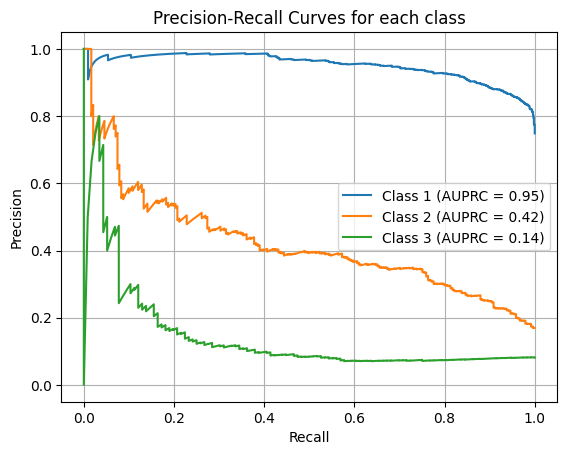


ROC Curves:


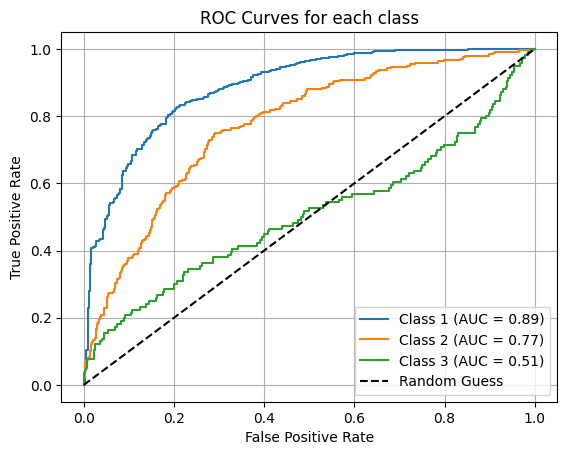


Mean F1 Score: 0.4653
Balanced Accuracy: 0.5306
Average AUPRC: 0.5036

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77      1063
           1       0.33      0.76      0.46       241
           2       0.16      0.18      0.17       116

    accuracy                           0.63      1420
   macro avg       0.48      0.53      0.47      1420
weighted avg       0.78      0.63      0.67      1420

__________________________________________________
Fold No: 4
training on folds: [[np.int64(4), np.int64(3), np.int64(0)]]
validation on folds: 1
test on folds: 2
Epoch [1/100], Loss: 1.0010, Accuracy: 0.4948 | Validation Loss: 1.0496, Validation Accuracy: 0.4562
Epoch [2/100], Loss: 0.8410, Accuracy: 0.6762 | Validation Loss: 0.8543, Validation Accuracy: 0.4909
Epoch [3/100], Loss: 0.8069, Accuracy: 0.6753 | Validation Loss: 0.8849, Validation Accuracy: 0.5276
Epoch [4/100], Loss: 0.7773, Accuracy: 0.7073 | Validation

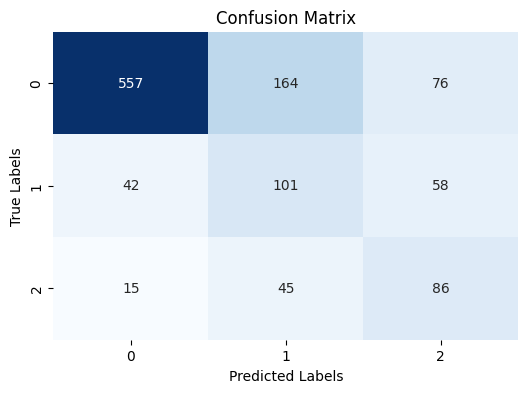


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 557/797 (69.89%)
Class 1: Correct Predictions / Total True Samples = 101/201 (50.25%)
Class 2: Correct Predictions / Total True Samples = 86/146 (58.90%)

Precision-Recall Curves:


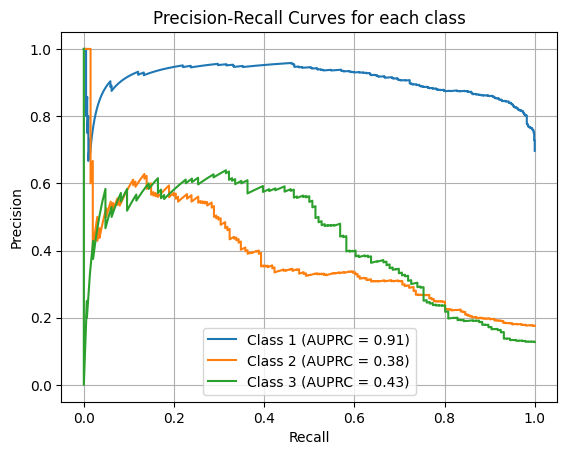


ROC Curves:


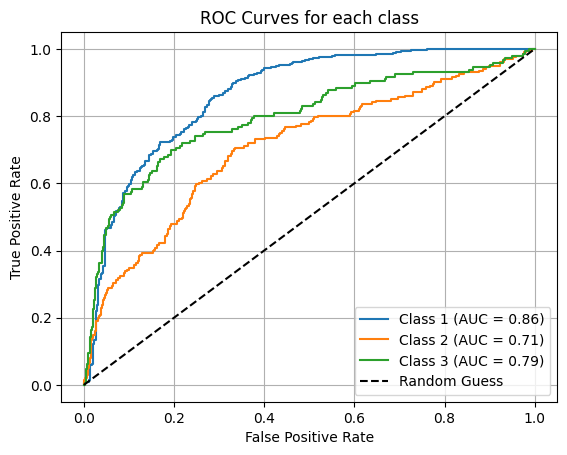


Mean F1 Score: 0.5516
Balanced Accuracy: 0.5968
Average AUPRC: 0.5722

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       797
           1       0.33      0.50      0.40       201
           2       0.39      0.59      0.47       146

    accuracy                           0.65      1144
   macro avg       0.54      0.60      0.55      1144
weighted avg       0.74      0.65      0.68      1144

__________________________________________________
Fold No: 5
training on folds: [[np.int64(4), np.int64(3), np.int64(1)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.0890, Accuracy: 0.3942 | Validation Loss: 0.8551, Validation Accuracy: 0.5291
Epoch [2/100], Loss: 0.8807, Accuracy: 0.6100 | Validation Loss: 0.8922, Validation Accuracy: 0.5431
Epoch [3/100], Loss: 0.7996, Accuracy: 0.6688 | Validation Loss: 0.9519, Validation Accuracy: 0.5404
Epoch [4/100], Loss: 0.7562, Accuracy: 0.7276 | Validation

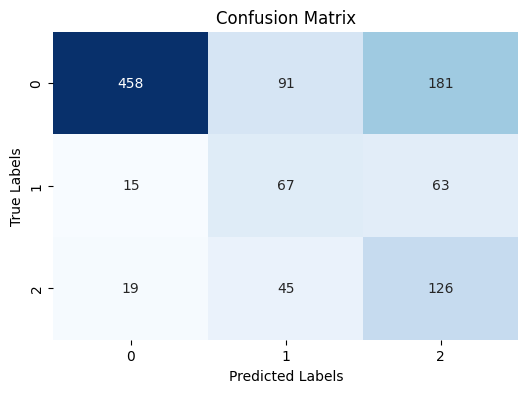


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 458/730 (62.74%)
Class 1: Correct Predictions / Total True Samples = 67/145 (46.21%)
Class 2: Correct Predictions / Total True Samples = 126/190 (66.32%)

Precision-Recall Curves:


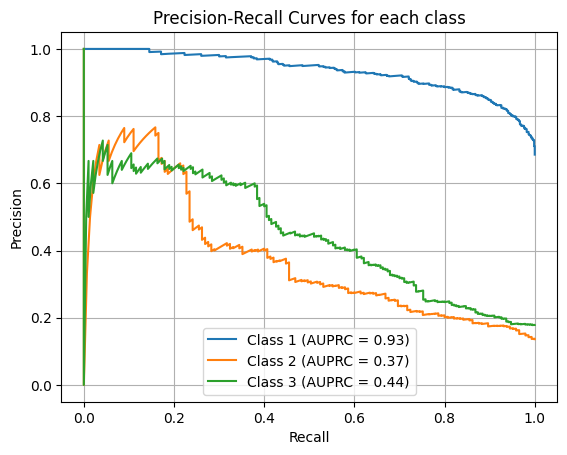


ROC Curves:


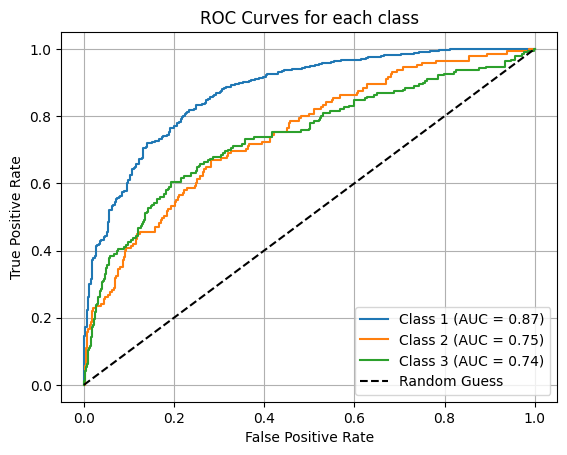


Mean F1 Score: 0.5282
Balanced Accuracy: 0.5842
Average AUPRC: 0.5835

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75       730
           1       0.33      0.46      0.39       145
           2       0.34      0.66      0.45       190

    accuracy                           0.61      1065
   macro avg       0.53      0.58      0.53      1065
weighted avg       0.74      0.61      0.65      1065

Accuracy for each fold: [np.float64(0.5552184646147212), np.float64(0.5967085257348801), np.float64(0.5305815984362112), np.float64(0.5967998078165345), np.float64(0.5842080401760187)]
AUPRC for each fold: [np.float64(0.562920791755482), np.float64(0.5886206204757142), np.float64(0.5035861425336642), np.float64(0.5722023755084772), np.float64(0.5835058407338308)]
Average AUPRC across all folds: 0.5621671542014337
Average Balanced Accuracy across all folds: 0.5727032873556732
____________________________________________

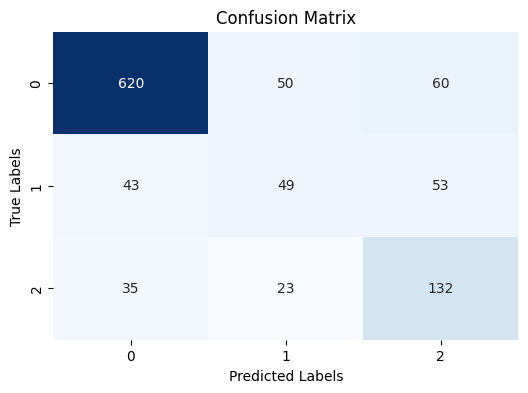


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 620/730 (84.93%)
Class 1: Correct Predictions / Total True Samples = 49/145 (33.79%)
Class 2: Correct Predictions / Total True Samples = 132/190 (69.47%)

Precision-Recall Curves:


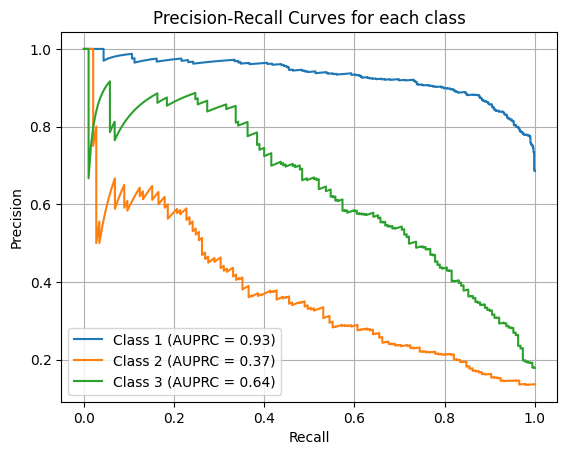


ROC Curves:


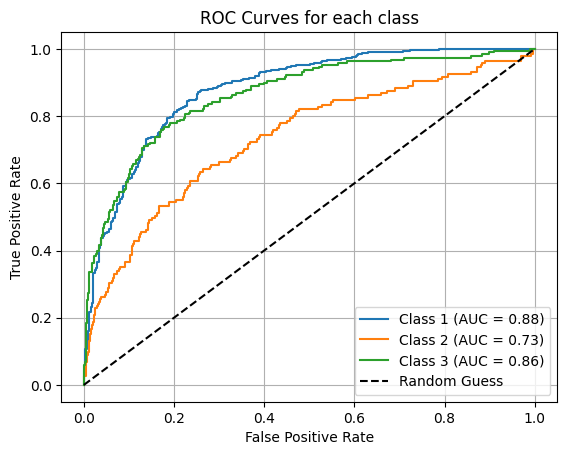


Mean F1 Score: 0.6141
Balanced Accuracy: 0.6273
Average AUPRC: 0.6465

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       730
           1       0.40      0.34      0.37       145
           2       0.54      0.69      0.61       190

    accuracy                           0.75      1065
   macro avg       0.61      0.63      0.61      1065
weighted avg       0.76      0.75      0.75      1065

__________________________________________________
Fold No: 2
training on folds: [[np.int64(2), np.int64(4), np.int64(1)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.1265, Accuracy: 0.3606 | Validation Loss: 0.9828, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1105, Accuracy: 0.3437 | Validation Loss: 1.0511, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1054, Accuracy: 0.3154 | Validation Loss: 1.1053, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1063, Accuracy: 0.3324 | Validation

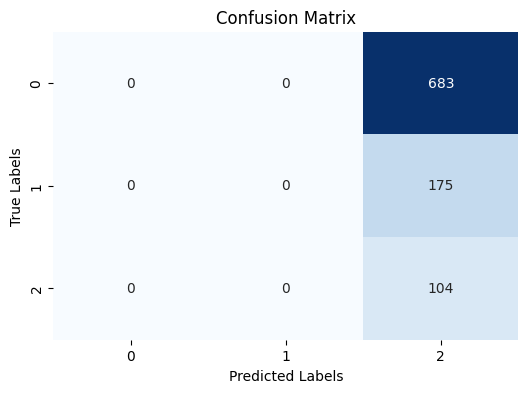


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/683 (0.00%)
Class 1: Correct Predictions / Total True Samples = 0/175 (0.00%)
Class 2: Correct Predictions / Total True Samples = 104/104 (100.00%)

Precision-Recall Curves:


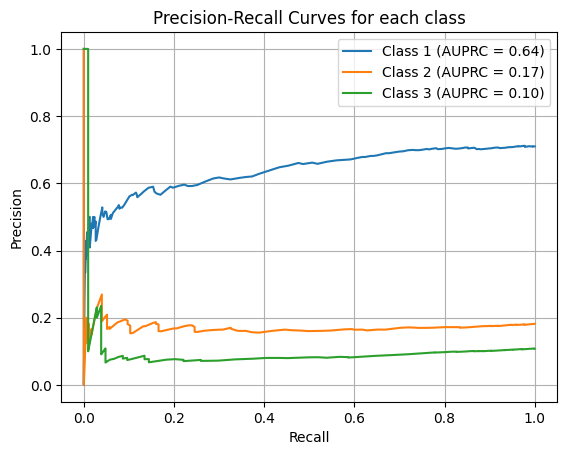


ROC Curves:


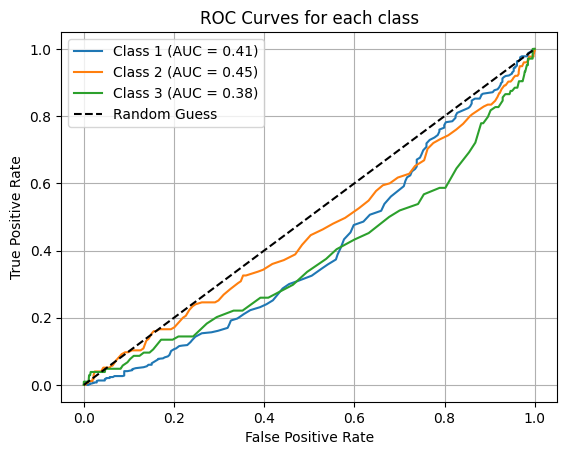


Mean F1 Score: 0.0650
Balanced Accuracy: 0.3333
Average AUPRC: 0.3021

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       683
           1       0.00      0.00      0.00       175
           2       0.11      1.00      0.20       104

    accuracy                           0.11       962
   macro avg       0.04      0.33      0.07       962
weighted avg       0.01      0.11      0.02       962

__________________________________________________
Fold No: 3
training on folds: [[np.int64(0), np.int64(4), np.int64(1)]]
validation on folds: 3
test on folds: 2


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1218, Accuracy: 0.3283 | Validation Loss: 1.1251, Validation Accuracy: 0.3602
Epoch [2/100], Loss: 1.0172, Accuracy: 0.5075 | Validation Loss: 0.9128, Validation Accuracy: 0.5500
Epoch [3/100], Loss: 0.9220, Accuracy: 0.6189 | Validation Loss: 0.8767, Validation Accuracy: 0.5693
Epoch [4/100], Loss: 0.8857, Accuracy: 0.6466 | Validation Loss: 1.0275, Validation Accuracy: 0.5657
Epoch [5/100], Loss: 0.8166, Accuracy: 0.7111 | Validation Loss: 0.7715, Validation Accuracy: 0.5846
Epoch [6/100], Loss: 0.7908, Accuracy: 0.7362 | Validation Loss: 0.7594, Validation Accuracy: 0.5800
Epoch [7/100], Loss: 0.7729, Accuracy: 0.7395 | Validation Loss: 0.7628, Validation Accuracy: 0.5898
Epoch [8/100], Loss: 0.7381, Accuracy: 0.7781 | Validation Loss: 1.0160, Validation Accuracy: 0.5678
Epoch [9/100], Loss: 0.7248, Accuracy: 0.7915 | Validation Loss: 0.7976, Validation Accuracy: 0.5894
Epoch [10/100], Loss: 0.7038, Accuracy: 0.8023 | Validation Loss: 0.8995, Validation Accura

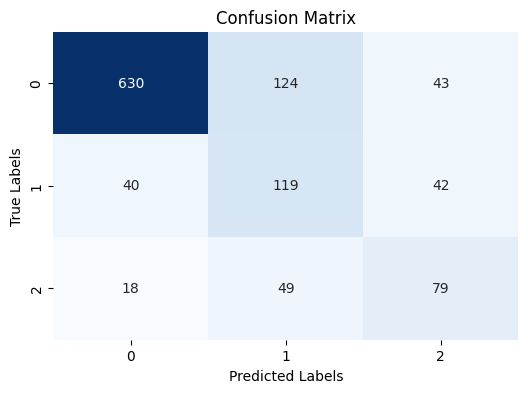


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 630/797 (79.05%)
Class 1: Correct Predictions / Total True Samples = 119/201 (59.20%)
Class 2: Correct Predictions / Total True Samples = 79/146 (54.11%)

Precision-Recall Curves:


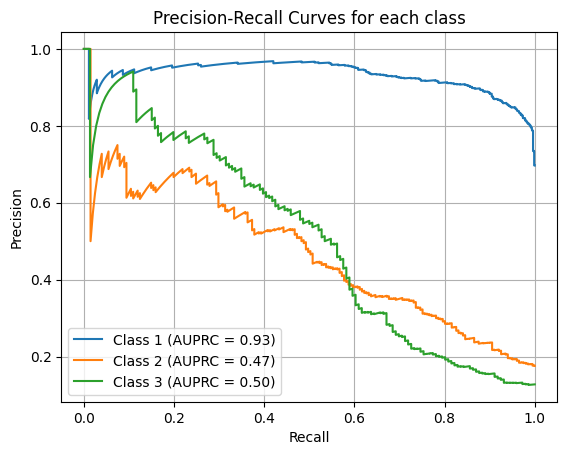


ROC Curves:


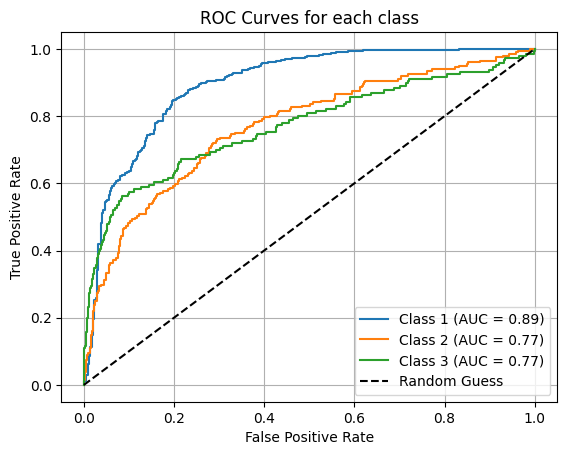


Mean F1 Score: 0.6136
Balanced Accuracy: 0.6412
Average AUPRC: 0.6345

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       797
           1       0.41      0.59      0.48       201
           2       0.48      0.54      0.51       146

    accuracy                           0.72      1144
   macro avg       0.60      0.64      0.61      1144
weighted avg       0.77      0.72      0.74      1144

__________________________________________________
Fold No: 4
training on folds: [[np.int64(0), np.int64(3), np.int64(1)]]
validation on folds: 2
test on folds: 4
Epoch [1/100], Loss: 1.1212, Accuracy: 0.3528 | Validation Loss: 1.2325, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1029, Accuracy: 0.3431 | Validation Loss: 0.9775, Validation Accuracy: 0.4565
Epoch [3/100], Loss: 1.0065, Accuracy: 0.5236 | Validation Loss: 1.1280, Validation Accuracy: 0.3828
Epoch [4/100], Loss: 1.0783, Accuracy: 0.4163 | Validation

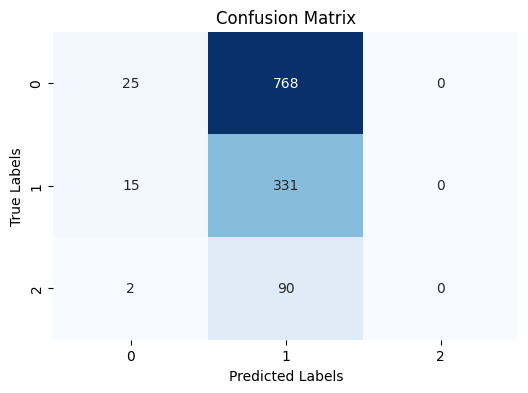


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 25/793 (3.15%)
Class 1: Correct Predictions / Total True Samples = 331/346 (95.66%)
Class 2: Correct Predictions / Total True Samples = 0/92 (0.00%)

Precision-Recall Curves:


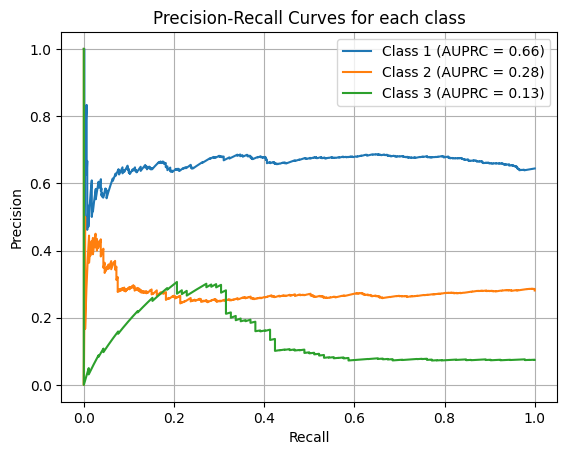


ROC Curves:


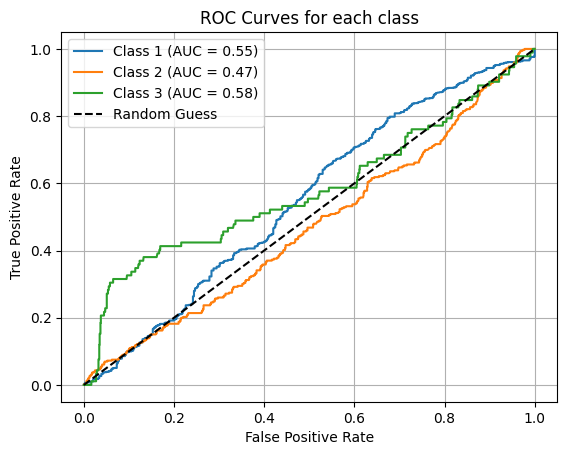


Mean F1 Score: 0.1637
Balanced Accuracy: 0.3294
Average AUPRC: 0.3570

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.03      0.06       793
           1       0.28      0.96      0.43       346
           2       0.00      0.00      0.00        92

    accuracy                           0.29      1231
   macro avg       0.29      0.33      0.16      1231
weighted avg       0.46      0.29      0.16      1231

__________________________________________________
Fold No: 5
training on folds: [[np.int64(0), np.int64(3), np.int64(2)]]
validation on folds: 4
test on folds: 1


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1077, Accuracy: 0.3583 | Validation Loss: 0.9464, Validation Accuracy: 0.3804
Epoch [2/100], Loss: 1.0001, Accuracy: 0.5235 | Validation Loss: 1.0705, Validation Accuracy: 0.5795
Epoch [3/100], Loss: 0.9452, Accuracy: 0.5833 | Validation Loss: 0.8869, Validation Accuracy: 0.6438
Epoch [4/100], Loss: 0.9045, Accuracy: 0.6280 | Validation Loss: 0.8488, Validation Accuracy: 0.6284
Epoch [5/100], Loss: 0.8871, Accuracy: 0.6447 | Validation Loss: 0.9827, Validation Accuracy: 0.5840
Epoch [6/100], Loss: 0.8736, Accuracy: 0.6652 | Validation Loss: 0.9150, Validation Accuracy: 0.5581
Epoch [7/100], Loss: 0.8591, Accuracy: 0.6879 | Validation Loss: 0.9325, Validation Accuracy: 0.6188
Epoch [8/100], Loss: 0.8189, Accuracy: 0.7174 | Validation Loss: 0.8277, Validation Accuracy: 0.5362
Epoch [9/100], Loss: 0.8220, Accuracy: 0.7144 | Validation Loss: 0.8615, Validation Accuracy: 0.5530
Epoch [10/100], Loss: 0.7928, Accuracy: 0.7515 | Validation Loss: 0.9092, Validation Accura

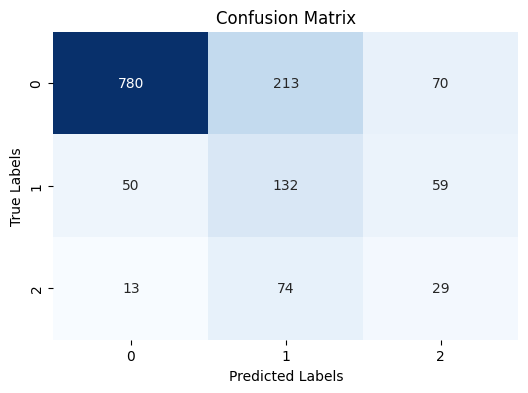


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 780/1063 (73.38%)
Class 1: Correct Predictions / Total True Samples = 132/241 (54.77%)
Class 2: Correct Predictions / Total True Samples = 29/116 (25.00%)

Precision-Recall Curves:


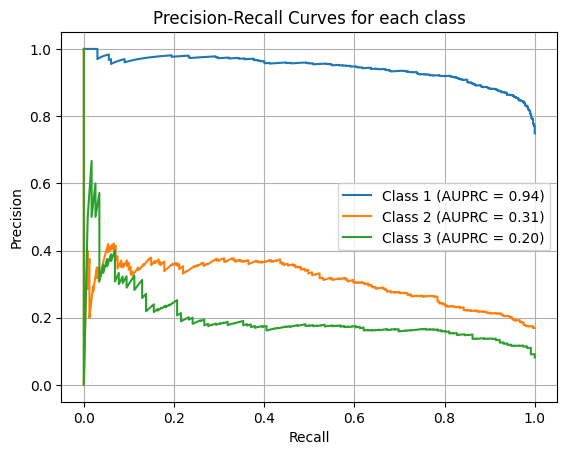


ROC Curves:


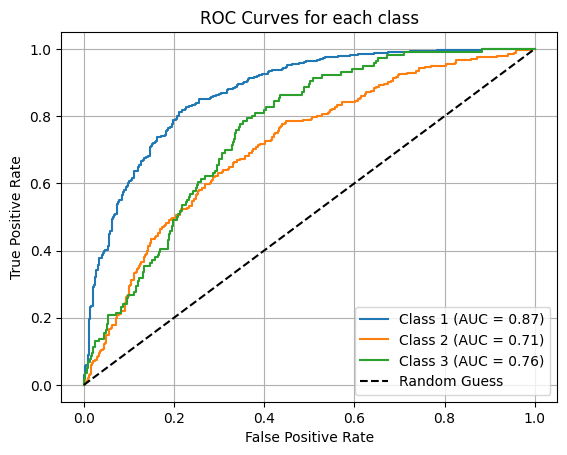


Mean F1 Score: 0.4767
Balanced Accuracy: 0.5105
Average AUPRC: 0.4822

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1063
           1       0.32      0.55      0.40       241
           2       0.18      0.25      0.21       116

    accuracy                           0.66      1420
   macro avg       0.47      0.51      0.48      1420
weighted avg       0.76      0.66      0.70      1420

Accuracy for each fold: [np.float64(0.6273276483603908), np.float64(0.3333333333333333), np.float64(0.6411999774364573), np.float64(0.3293910833473043), np.float64(0.5104967282502483)]
AUPRC for each fold: [np.float64(0.6465482552128986), np.float64(0.30205100806898716), np.float64(0.63445741778403), np.float64(0.3570140735373865), np.float64(0.4821506199695653)]
Average AUPRC across all folds: 0.4844442749145735
Average Balanced Accuracy across all folds: 0.4883497541455468


In [ ]:

import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc





all_params = [
    {"num_heads": 32, "num_transformer_blocks": 8, "learning_rate": 0.0014268683384269449, "weight_decay": 0.0003463319958859285, "label_smoothing": 0.18},
{"num_heads": 16, "num_transformer_blocks": 8, "learning_rate": 0.0013696721515052846, "weight_decay": 0.0009676440016847239, "label_smoothing": 0.04},
{"num_heads": 32, "num_transformer_blocks": 8, "learning_rate": 0.0005740396891375217, "weight_decay": 0.0007863640188002474, "label_smoothing": 0.23},
{"num_heads": 8, "num_transformer_blocks": 8, "learning_rate": 0.0002850701467255021, "weight_decay": 0.0009773517427519572, "label_smoothing": 0.1},
{"num_heads": 2, "num_transformer_blocks": 8, "learning_rate": 0.0008196533938204881, "weight_decay": 0.0009674378890685176, "label_smoothing": 0.16}

]

for param_id in range(len(all_params)):

    params = all_params[param_id]
    
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print(f"PARAMS SET {param_id}")\
        #print the parameters
    print(f"num_heads: {params['num_heads']}, num_transformer_blocks: {params['num_transformer_blocks']}, learning_rate: {params['learning_rate']}, weight_decay: {params['weight_decay']}, label_smoothing: {params['label_smoothing']}")

    print("_"*50)
    print("_"*50)
    print("_"*50)


    # Fold indices and other configurations
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3
    epochs = 100
    input_shape = (3,224,224)
    embed_dim = 128
    num_heads = params['num_heads']
    num_transformer_blocks = params['num_transformer_blocks']
    learning_rate = params['learning_rate']
    optimizer = "Adam"
    weight_decay = params['weight_decay']
    batch_size = 16

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   

    # Training loop for cross-validation
    for fold_idx in range(5):
        
        torch.cuda.empty_cache()
        print("_"*50)
        
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = TRANS_CNN(input_shape=input_shape,num_classes=num_classes,embed_dim=128,num_heads=num_heads,num_transformer_blocks=num_transformer_blocks) # Initialize your model here
        fold_model.to(device)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=params['label_smoothing'])# Use label smoothing if specified
        optimizer = optim.AdamW(fold_model.parameters(), lr=learning_rate,weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]
        
        print(f"training on folds: {[train_folds]}")
        print(f"validation on folds: {val_fold}")
        print(f"test on folds: {test_fold}")
        

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f} | Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
